# Lecture 1

## Introduction

## Setup

In [3]:
%matplotlib inline

In [4]:
path = "data/dogscats/sample/"

In [6]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from importlib import reload

In [7]:
import utils
reload(utils)
from utils import plots

Using TensorFlow backend.


# Use a pretrained VGG model with Vgg16 class

## The puchline: state of the art custom model in 7 lines of code

In [8]:
batch_size = 64

In [10]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

## Use Vgg16 for basic image recognition

In [11]:
vgg = Vgg16()

C:\Users\hjkim\AnacondaProjects\fastai\courses\deeplearning1\nbs\vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\Users\hjkim\AnacondaProjects\fastai\courses\deeplearning1\nbs\vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\Users\hjkim\AnacondaProjects\fastai\courses\deeplearning1\nbs\vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))
C:\Users\hjkim\AnacondaProjects\fastai\courses\deeplearning1\nbs\vgg16.py:100: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(512, (3, 3), activation="relu")`
  model.add(Convolution2D(filters, 3, 3, activation='relu'))


In [12]:
batches = vgg.get_batches(path + 'train', batch_size = 4)

Found 16 images belonging to 2 classes.


*Batches* is just a regular python iterator. Each iteration returns both the images themselves, as well as the labels.

In [16]:
imgs, labels = next(batches)

As you can see, the lables for each image are an array, containing a 1 in the first position if it is a cat, and in the second position if it is a dog. This approach to encode categorical variables, where an array containing just a single 1 in the position corresponding to the category, is very common in deep learning. It is called *one hot encoding*.

The arrays contain two elements, because we have two categories (cat and dog). If we had three categories (e.g. cats, dogs and kangaroos), then the arrays would contain two 0's, and one 1.

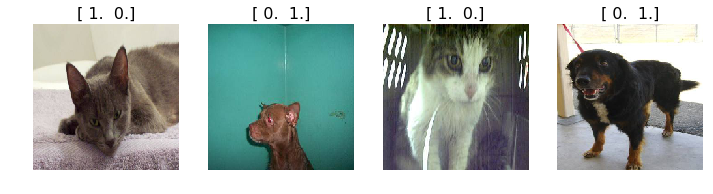

In [18]:
plots(imgs, titles=labels)

We can now pass the images to Vgg16's predict() function to get back probabilities, category indexes, and category names for each image's VGG prediction.

The category indexes are based on the ordering of categories uesd in the VG model - e.g. here are the first 4:

(Note that, other than creating the Vgg16 object, none of these steps are necessary to build a model; there are just showing how to use the class to biew imagenet prediction.)

## Use out Vgg16 class to finetune a Dogs vs Cats model
To change out model so that it outputs "cat" vs "dog", instead of one of 1,000 very specific categories, we need to use a process called "finetuning". Finetunning looks from the outside to be identicalt o normal machien learning training - we provide a training set with data and labels to learn from, and a validation set ot test againtst. The model learns a set of parametesr based on the data provided.

However, teh diffrernce is taht we start with a model that is already trained to solve a similar problem. The idea is that many of the parameters should be very simlar, or the same, betweem the existin gmodel, and the model we wish to create. Therefore, we only select a subset of parameters to train, and leave the rest untouched. This happens automatically when we call *fit()* after training, and to avoif running out of memory.

In [19]:
batch_size = 4

In [21]:
batches = vgg.get_batches(path + 'train', batch_size = batch_size)
val_batches = vgg.get_batches(path + 'valid', batch_size = batch_size)

batches.nb_class = batches.num_class
batches.nb_sample = batches.samples
val_batches.nb_class = val_batches.num_class
val_batches.nb_sample = val_batches.samples

Found 16 images belonging to 2 classes.
Found 8 images belonging to 2 classes.


Calling *finetune()* modifies the model such that it will be trained based on the data in the batches provided - in this case, to predict either 'dog' or 'cat'.

In [22]:
vgg.finetune(batches)

Finally, we *fit()* the parameters of teh model using the training data, reporting the accuracy on the validation set after every epoch. (An *epoch* is one full pass through the training data.)

In [24]:
vgg.fit(batches, val_batches, nb_epoch = 1)

C:\Users\hjkim\AnacondaProjects\fastai\courses\deeplearning1\nbs\vgg16.py:213: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
C:\Users\hjkim\AnacondaProjects\fastai\courses\deeplearning1\nbs\vgg16.py:213: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=<keras.pre..., steps_per_epoch=4, epochs=1, validation_steps=8)`
  validation_data=val_batches, nb_val_samples=val_batches.nb_sample)


Epoch 1/1
4/4 [==============================] - 85s - loss: 1.1461 - acc: 0.3125 - val_loss: 0.2056 - val_acc: 0.8750


That shows all of the steps involved in using the Vgg16 class ti create an image recognition model using whatever labels you are interested in. For instance, this process could classify paintings by style, or leaves by type of disease, or statellite photos by type of vrop, and so forth..

Next up, we'll dig ont level deeper to see what's going on in the Vgg16 class.

# Create a VGG model from scratch in Keras
We will recreate from scratch the functionality we just used. This is not necessary if all you want to do is use the existing model - but if tou want to create your own models, you'll need to understand these details. It will also help you in the future when you debug any problems with your models, since you'll understand what's going behind the scenes.

## Model setup
We need to import all the modules we'll be using from numpy, scipy, and keras:

In [18]:
from importlib import reload
import utils
reload(utils)

import numpy as np

from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

Let's import the mappings from VGG ids to imagenet category ids and descriptions, for display purpose later.

In [19]:
FILES_PATH='http://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'

# Keras's get_file() is a handy function that downloads files, and chaches them for e-use later
fpath = get_file(CLASS_FILE, FILES_PATH + CLASS_FILE, cache_subdir = 'models')
with open(fpath) as f: class_dict = json.load(f)

# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

Here's a few examples of the categories we just imported:

In [20]:
classes[:5]

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']

## Model creation
Creating the model involves creating the model architecture, and then loading the model weights into that architecture. We will start by definin gthe baseic prices of the VGG architecture.

VGG has just one type of convolution block, and ont type of fully connected ('dense') block. Here's the convolutional block definition:

In [21]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2,2)))

... and here's the fully-connected definition.

In [22]:
def FCBlock(model):
    model.add(Dense(4096, activation = 'relu'))
    model.add(Dropout(0.5))

When the VGG model was trained in 2014, the creators subtracted the average of each of the three (R,G,B) channels first, so that the data for each channel had a mean of zero. Furthermode, their fostware that expected the channels to be in B, G, R order, whereas Python by default uese R, G, B. We need to preprocess out data to make these two changes, so that it is compatible wirh the VGG model:

In [23]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1]

Now we're ready to define the VGG model architecture - look at how simple it is, now we have the basic blocks defined!

In [24]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape = (3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation = 'softmax'))
    return model

We will learn about what hese different blocks do later in the course. For now, it's enough to know that:
- Convolution layers are for finding paterns in images
- Dense (fully connected) layers are for combining pattern accross an image

Now that we've defined the architecture, we can create the model like any python object:

In [25]:
model = VGG_16()

As well as the architecture, we need the weights that the VGG creators trained. The weights are the part of the model that is learnt from the data, whereas the architecture is pre-defiend based onthe nature of the problem.

Downloading pre-defined weights is much preferred to training the model ourselves, since otherwise we would have to downlaod the entire Imagenet archieve, and train the model for manydays. It's very helpful when reserachers release their wieghts, as they did here.

In [26]:
fpath = get_file('vgg16.h5', FILES_PATH + 'vgg16.h5', cache_subdir = 'models')
model.load_weights(fpath)

## Getting imagenet predictions
The setup of the imagenet model is now complete, so all we have to do is grab a batch of images and call *predict()* on them.

In [27]:
batch_size = 4

Keras provides functionality to create batches of data from directories containing images; all we have to do is to define the size to resize the images to, what type of lables to create, whether to randomly suffle the images, and how many images to include in each batch. We use this little wrapper to define some helpful defaults appropriate for imagenet data:

In [28]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle = True, batch_size = batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path + dirname, target_size = (224,224), class_mode = class_mode, shuffle = shuffle, batch_size = batch_size)

From here we can use exactly the same steps as before to look at predictions from the model:

In [29]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs, labels = next(batches)

# This show the 'ground truth'
plots(imgs, titles = labels)

NameError: name 'path' is not defined

The VGG model returns 1,000 probabilities for each iamge, representing the probability that the model assigns to each prssible imagenet categfory for each image,. By finding the index with the largest probability (with *np,argmax()*) we van find the predicted label.

In [102]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print('    {:.4f}/{}'.format(preds[i,idx], classes[idx]))

In [103]:
pred_batch(imgs)

ValueError: Error when checking : expected lambda_6_input to have shape (None, 3, 224, 224) but got array with shape (4, 3, 223, 223)